# Create an image classification solution with Tensorflow

opening first image: data_set/darth_vader/0014.jpeg


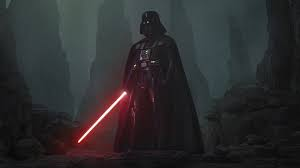

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

# Setup image folder
import pathlib

data_dir = pathlib.Path('data_set')
image_paths = list(data_dir.glob('*/*.jpeg'))
print('opening first image:', image_paths[0])
PIL.Image.open(str(image_paths[0]))

create a set for training the model

In [7]:
# Create a dataset, 
# the images will be resized automatically using the image_dataset_from_directory() utility
batch_size = 5
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26 files belonging to 2 classes.
Using 21 files for training.


2023-01-08 14:26:35.125257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


create a set for validating the model

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26 files belonging to 2 classes.
Using 5 files for validation.


find the classnames used

In [9]:
class_names = train_ds.class_names
print(class_names)

['darth_vader', 'storm_trooper']


See what an image looks like as a tensor:
(it is an array of 180 pixels rows with 180 pixels each (from left to right), each pixel has an RBG color value of [0-255, 0-255, 0-255])

In [10]:
image0, class0 = list(train_ds)[0]
image0
#print(np.min(image0), np.max(image0))

<tf.Tensor: shape=(5, 180, 180, 3), dtype=float32, numpy=
array([[[[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],

        [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],

        [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         [2

Visualize/check the (resized) data using pyplot

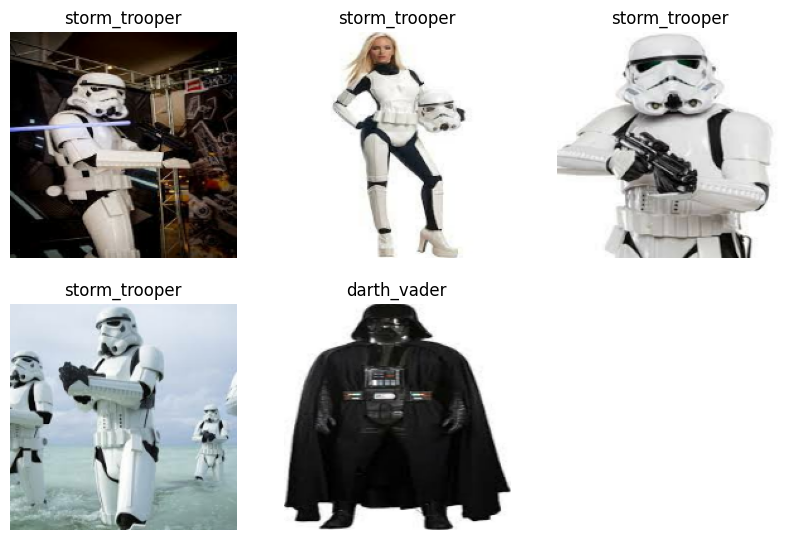

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # take one batch of 5
  for i in range(len(images)):
    ax = plt.subplot(3, 3, i + 1)
    imageArray = images[i].numpy().astype("uint8")    
    plt.imshow(imageArray)
    plt.title(class_names[labels[i]])
    plt.axis("off")

manually iterate over the dataset and retrieve batches of images

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break # stop after first iteration


(5, 180, 180, 3)
(5,)


The image_batch is a tensor of the shape (5, 180, 180, 3).

This is a batch of 5 images of shape 180x180x3 (the last dimension refers to color channels RGB). 

The label_batch is a tensor of the shape (5,), these are corresponding labels to the 5 images.

The RGB channel values are in the [0, 255] range.
This is not ideal for a neural network; in general you should seek to make your input values small.

In [ ]:
normalization_layer = layers.Rescaling(1./255) # creates a funtion

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds)) #another way to get the first element of the iterable training set
first_image = image_batch[0]
first_image
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


#### A basic (Keras) Sequential Model

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), #flattens from an 2d array of [180, 180] to 1d array [32400]
  layers.Dense(1000, activation='relu'), # 1000 = number of neurons in a network layer, that decide if an image matches
  layers.Dense(num_classes)
])

model.summary() # view summary of the model


2023-01-08 14:30:12.043920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1585971200 exceeds 10% of free system memory.
2023-01-08 14:30:12.626521: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1585971200 exceeds 10% of free system memory.
2023-01-08 14:30:13.920678: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1585971200 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

Choose the *tf.keras.optimizers.Adam optimizer* and *tf.keras.losses.SparseCategoricalCrossentropy* loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [61]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #Computes how often integer targets are in the top K predictions.
  metrics=['accuracy']) #monitor accuracy after each training epoch


#### Train

train the model by fitting the training data and testing the accuracy and then testing the accuracy using the validation data.

During the different of epochs (optimization runs) keep a close eay on the *increase* in accuracy:

In [62]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
5/5 [==============================] - 2s 307ms/step - loss: 0.9385 - accuracy: 0.4762 - val_loss: 0.5599 - val_accuracy: 0.8000
Epoch 2/3
5/5 [==============================] - 0s 75ms/step - loss: 0.4885 - accuracy: 0.8571 - val_loss: 0.4257 - val_accuracy: 1.0000
Epoch 3/3
5/5 [==============================] - 0s 82ms/step - loss: 0.2338 - accuracy: 0.9524 - val_loss: 0.1716 - val_accuracy: 1.0000



### Visualize Training Accurracy and Validation Accuracy
To help you create better models make the training accuracy and validation accuracy visible in a plot.

Epoch 1/10
5/5 [==============================] - 1s 115ms/step - loss: 4.0434 - accuracy: 0.3333 - val_loss: 0.6779 - val_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 70ms/step - loss: 0.6756 - accuracy: 0.5238 - val_loss: 0.6443 - val_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 66ms/step - loss: 0.6327 - accuracy: 0.5238 - val_loss: 0.6312 - val_accuracy: 0.6000
Epoch 4/10
5/5 [==============================] - 0s 65ms/step - loss: 0.6182 - accuracy: 0.5238 - val_loss: 0.6129 - val_accuracy: 0.6000
Epoch 5/10
5/5 [==============================] - 0s 63ms/step - loss: 0.6165 - accuracy: 0.6190 - val_loss: 0.5727 - val_accuracy: 0.6000
Epoch 6/10
5/5 [==============================] - 0s 65ms/step - loss: 0.5584 - accuracy: 0.6667 - val_loss: 0.5247 - val_accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 0s 89ms/step - loss: 0.5589 - accuracy: 0.7619 - val_loss: 0.4627 - val_accuracy: 0.8000
Epoch 8/10
5/5 [==========

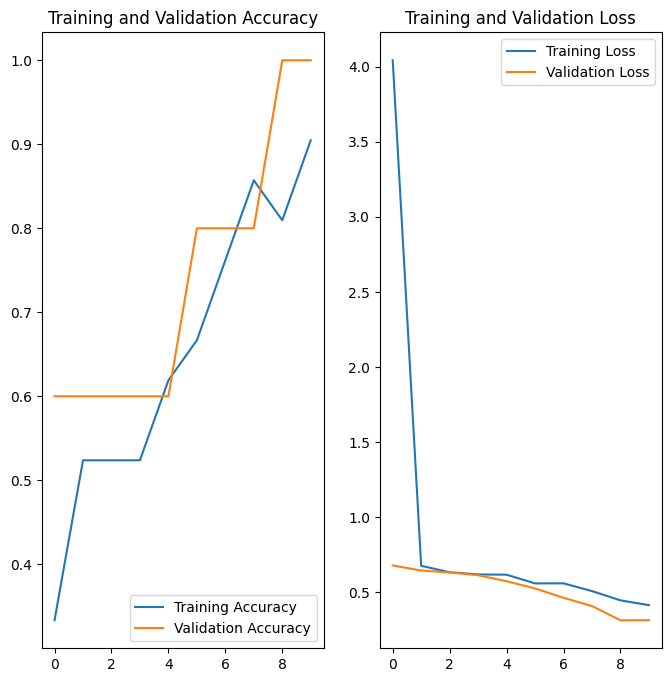

In [55]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Improving your model

##### Overfitting
If the accuracy it start to decline or stagnate (after peaking) it means there is overfitting: 
The training data starts to fit the model too perfectly! (When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples) While the accuracy on the validation set is not improving. Not good: what you really want is to develop models that do well on a data set they haven't seen before.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.


##### Underfitting
The opposite of overfitting is underfitting. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

In [54]:
# Data augmentation takes the approach of generating additional training data from 
# your existing examples by augmenting them using random transformations that yield 
# believable-looking images. This helps expose the model to more aspects of the data 
# and generalize better.
# 
# uncomment lines below to add more data
model = Sequential([
#  layers.RandomFlip("horizontal",
#                      input_shape=(img_height,
#                                  img_width,
#                                  3)),
#  layers.RandomRotation(0.1),
#  layers.RandomZoom(0.1),
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  #run previous step to see the plot again

# Predict on new data

In [ ]:
unclassified_image_url = "https://www.captain-hook.nl/controller/images/003394c0a45a936a58f44658e9fc05d2.jpg"
# save to keras cache
unclassified_image_path = tf.keras.utils.get_file('unclassified.jpeg', origin=unclassified_image_url)
print(unclassified_image_path)
PIL.Image.open(unclassified_image_path)

In [94]:
img = tf.keras.utils.load_img(
    unclassified_image_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to darth_vader with a 78.57 percent confidence.


Save model
Use TensorFlow Lite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


Load the tflite model in Python

In [103]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
# get input and output
interpreter.get_signature_list()




{'serving_default': {'inputs': ['rescaling_3_input'], 'outputs': ['dense_7']}}

Use the output from the previous block to identify the runner, first input layer,  and the last output layer

i.e. {'serving_default': {'inputs': ['rescaling_3_input'], 'outputs': ['dense_7']}}

In [107]:
runner = 'serving_default'
inputs = 'rescaling_3_input'
outputs = 'dense_7'

classify_lite = interpreter.get_signature_runner(runner)
predictions_lite = classify_lite(rescaling_3_input=img_array)[outputs] 
score_lite = tf.nn.softmax(predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)
print('dif between normal and lite model prediction', np.max(np.abs(predictions - predictions_lite)))



This image most likely belongs to darth_vader with a 78.57 percent confidence.
dif between normal and lite model prediction 5.364418e-07
